In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\kuzey\OneDrive\Masaüstü\fizik_proje\SDSS_DR18.csv")

label_map = {'STAR': 0, 'GALAXY': 1, 'QSO': 2}
df['label'] = df['class'].map(label_map)

features_to_use = [
    'u', 'g', 'r', 'i', 'z',
    'petroRad_u', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'petroRad_z',
    'petroFlux_u', 'petroFlux_g', 'petroFlux_r', 'petroFlux_i', 'petroFlux_z',
    'petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z',
    'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
    'expAB_u', 'expAB_g', 'expAB_r', 'expAB_i', 'expAB_z',
    'redshift'
]

df = df.dropna(subset=features_to_use + ['label'])

def augment_class(df, label_value, target_count, noise_strength=0.01):
    current_df = df[df['label'] == label_value]
    current_count = len(current_df)
    
    if current_count >= target_count:
        return current_df.copy()

    needed = target_count - current_count
    print(f"🔁 Augmenting class {label_value}: +{needed} rows")

    repeats = needed // current_count + 1
    augmented = pd.concat([current_df] * repeats, ignore_index=True).sample(needed, random_state=42)

    for col in features_to_use:
        noise = np.random.normal(0, noise_strength, size=augmented.shape[0])
        augmented[col] += noise

    return pd.concat([current_df, augmented], ignore_index=True)

df_star_aug = augment_class(df, label_value=0, target_count=52343)
df_qso_aug = augment_class(df, label_value=2, target_count=52343)
df_galaxy  = df[df['label'] == 1]  # Already balanced

df_augmented = pd.concat([df_galaxy, df_star_aug, df_qso_aug], ignore_index=True).sample(frac=1, random_state=42)
print(f"✅ Augmented dataset shape: {df_augmented.shape}")
print(df_augmented['label'].value_counts())


🔁 Augmenting class 0: +15111 rows
🔁 Augmenting class 2: +41918 rows
✅ Augmented dataset shape: (157029, 44)
label
1    52343
2    52343
0    52343
Name: count, dtype: int64


In [ ]:
df_augmented.to_csv("augmented_SDSS.csv", index=False)

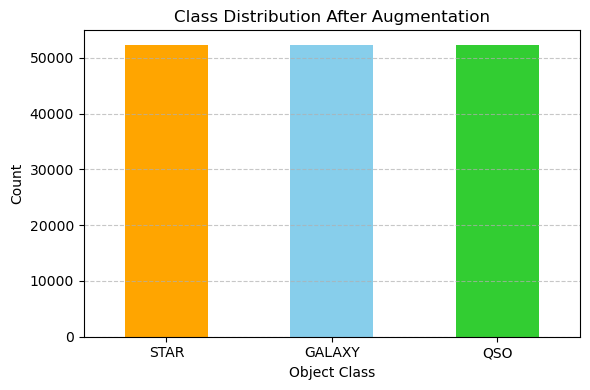

In [11]:
import matplotlib.pyplot as plt

aug_class_counts = df_augmented['label'].value_counts().sort_index()

label_names = {0: 'STAR', 1: 'GALAXY', 2: 'QSO'}
aug_class_counts.index = aug_class_counts.index.map(label_names)

plt.figure(figsize=(6, 4))
aug_class_counts.plot(kind='bar', color=['orange', 'skyblue', 'limegreen'])
plt.title("Class Distribution After Augmentation")
plt.xlabel("Object Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


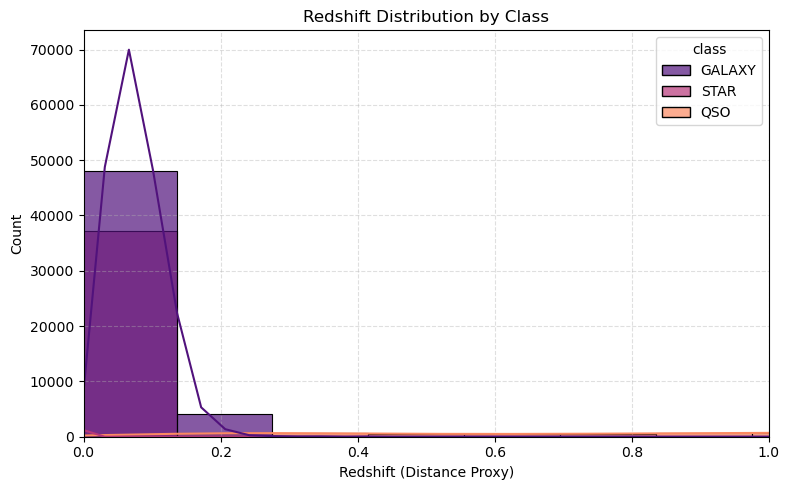

In [7]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(data=df, x='redshift', hue='class', bins=50, kde=True, palette='magma', alpha=0.7)
plt.title("Redshift Distribution by Class")
plt.xlabel("Redshift (Distance Proxy)")
plt.ylabel("Count")
plt.xlim(0, 1)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


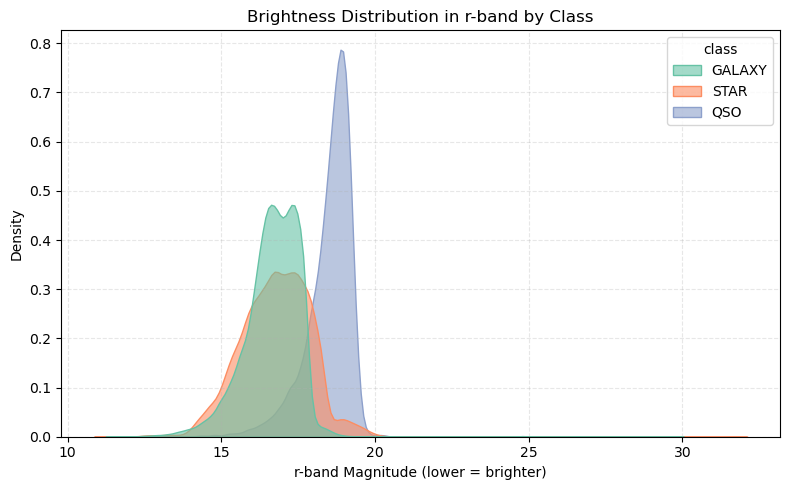

In [8]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x='r', hue='class', fill=True, common_norm=False, palette='Set2', alpha=0.6)
plt.title("Brightness Distribution in r-band by Class")
plt.xlabel("r-band Magnitude (lower = brighter)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()